## Imports and Custom Functions

In [1]:
#Imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import spacy
import nltk
import math

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import itertools
pd.set_option('display.max_colwidth',300)


from nltk.probability import FreqDist
from wordcloud import WordCloud
pd.set_option('display.max_colwidth', None)

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
def batch_preprocess_texts(
    texts,
    nlp=None,
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=False,
    disable=["ner"],
    batch_size=50,
    n_process=-1,
):
    """Efficiently preprocess a collection of texts using nlp.pipe()
    Args:
        texts (collection of strings): collection of texts to process (e.g. df['text'])
        nlp (spacy pipe), optional): Spacy nlp pipe. Defaults to None; if None, it creates a default 'en_core_web_sm' pipe.
        remove_stopwords (bool, optional): Controls stopword removal. Defaults to True.
        remove_punct (bool, optional): Controls punctuation removal. Defaults to True.
        use_lemmas (bool, optional): lemmatize tokens. Defaults to False.
        disable (list of strings, optional): named pipeline elements to disable. Defaults to ["ner"]: Used with nlp.pipe(disable=disable)
        batch_size (int, optional): Number of texts to process in a batch. Defaults to 50.
        n_process (int, optional): Number of CPU processors to use. Defaults to -1 (meaning all CPU cores).
    Returns:
        list of tokens
    """
    # from tqdm.notebook import tqdm
    from tqdm import tqdm
    if nlp is None:
        nlp = spacy.load("en_core_web_sm")
    processed_texts = []
    for doc in tqdm(nlp.pipe(texts, disable=disable, batch_size=batch_size, n_process=n_process)):
        tokens = []
        for token in doc:
            # Check if should remove stopwords and if token is stopword
            if (remove_stopwords == True) and (token.is_stop == True):
                # Continue the loop with the next token
                continue
            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_punct == True):
                continue
            # Check if should remove stopwords and if token is stopword
            if (remove_punct == True) and (token.is_space == True):
                continue
            
            ## Determine final form of output list of tokens/lemmas
            if use_lemmas:
                tokens.append(token.lemma_.lower())
            else:
                tokens.append(token.text.lower())
        processed_texts.append(tokens)
    return processed_texts


In [4]:

def get_ngram_measures_finder(tokens, ngrams=2, measure='raw_freq', top_n=None, min_freq = 1,
                             words_colname='Words'):
    import nltk
    if ngrams == 4:
        MeasuresClass = nltk.collocations.QuadgramAssocMeasures
        FinderClass = nltk.collocations.QuadgramCollocationFinder
        
    elif ngrams == 3: 
        MeasuresClass = nltk.collocations.TrigramAssocMeasures
        FinderClass = nltk.collocations.TrigramCollocationFinder
    else:
        MeasuresClass = nltk.collocations.BigramAssocMeasures
        FinderClass = nltk.collocations.BigramCollocationFinder

    measures = MeasuresClass()
    
   
    finder = FinderClass.from_words(tokens)
    finder.apply_freq_filter(min_freq)
    if measure=='pmi':
        scored_ngrams = finder.score_ngrams(measures.pmi)
    else:
        measure='raw_freq'
        scored_ngrams = finder.score_ngrams(measures.raw_freq)

    df_ngrams = pd.DataFrame(scored_ngrams, columns=[words_colname, measure.replace("_",' ').title()])
    if top_n is not None:
        return df_ngrams.head(top_n)
    else:
        return df_ngrams



## Load and Inspect Data

In [5]:
df = pd.read_csv("Data-NLP/movie_reviews_v2.csv")
df.head()

,review_id,movie_id,imdb_id,original_title,review,rating
0,64ecc16e83901800af821d50,843,tt0118694,花樣年華,"This is a fine piece of cinema from Wong Kar-Wai that tells us a story of two people whom circumstance throws together - but not in a way you might expect. We start with two couples who move into a new building. One a newspaper man with his wife, the other a business executive and his wife. The businessman is rarely at home, nor is the journalist's wife - which leaves the other two at increasingly loose ends. It isn't long before a friendship develops - usually over some noodles - and though entirely platonic, their relationship becomes solid and trusting. Then, something entirely unexpected occurs that causes the two to refocus their relationship in the face of betrayal and disappointment - and well.... What helps this film stand out are the performances from both Tony Leung (""Chow Mo-wan"") and the gorgeous Maggie Cheung (""Mrs. Chan"") - it's a love story, and it burns intensely - but not physically - as their story subsumes both themselves and the audience. The film looks marvellous, is paced stylishly and uses quite a bit of Nat King Cole to set and keep the mood atmospheric, romantic and interesting. The photography offers us lingering close ups, we get a sense of them falling in love as if we, too, were undergoing the same experience and that all adds to the richness of the story. To give us a breather from the intensity, there are some fun scenes with their very close neighbours who love nothing better than to sit up all night playing mahjong!! Super film, this - flew by.",7.0
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0
2,5bb5ac829251410dcb00810c,7443,tt0120630,Chicken Run,"Made my roommate who hates stop-motion animation watched this in 2018 and even he had a good time. It's maybe not as great as I remember thinking it was when I was a little kid, but it still holds up to some degree.\r\n\r\n_Final rating:★★★ - I liked it. Would personally recommend you give it a go._",6.0
3,5f0c53a013a32000357ec505,7443,tt0120630,Chicken Run,"A very good stop-motion animation!\r\n\r\n<em>'Chicken Run'</em>, which I watched a crap tonne when I was little but not for a vast number of years now, is an impressive production given it came out in 2000. Despite a pretty simple feel to the film, it's a very well developed concept.\r\n\r\nThe, admittedly short, run time truly flies by. Of course everything looks, relatively, terrific, but I'm impressed by the pacing which is clean. As for the cast, Julia Sawalha is the definite standout - she's fantastic as Ginger. Timothy Spall and Phil Daniels, as rats Nick and Fetcher, are amusing. Mel Gibson (Rocky), though still decent, isn't actually that good in this.\r\n\r\nA fun and interesting story! Definitely worth seeing if you haven't already. I'm intrigued to see where they go with the upcoming sequel.",8.0
4,64ecc027594c9400ffe77c91,7443,tt0120630,Chicken Run,"Ok, there is an huge temptation to riddle this review with puns - but I'm just going to say it's a cracking little family adventure. It's seemingly based on a whole range of classic movies from the ""Great Escape"", ""Star Trek"" to ""Love Story"" with a score cannibalised from just about any/everything ever written by Messrs. Korngold/Williams & Bernstein all adding to this really super stop-motion animation that Ray Harryhausen would have been proud of.. A flock of chickens are relentlessly exploited for their eggs by the evil ""Mrs Tweedy"" - that is, until ""Rocky"" (an on-form Mel Gibson) arrives over the fence and incites escape plans... Meantime their malevolent owner (Miranda Richardson) has plans to industrialise production - and this time, not just of the eggs..

In [6]:
# Number of reviews
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8650 entries, 0 to 8649
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   review_id       8650 non-null   object 
 1   movie_id        8650 non-null   int64  
 2   imdb_id         8650 non-null   object 
 3   original_title  8650 non-null   object 
 4   review          8650 non-null   object 
 5   rating          7454 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 405.6+ KB


In [7]:
# Ratings Distribution
df.describe()

,movie_id,rating
count,8.650000e+03,7454.000000
mean,2.714300e+05,6.497854
std,2.392418e+05,2.159961
min,1.200000e+01,0.500000
25%,3.664800e+04,5.000000
50%,2.719690e+05,7.000000
75%,4.390790e+05,8.000000
max,1.162322e+06,10.000000


<Axes: xlabel='rating', ylabel='Count'>

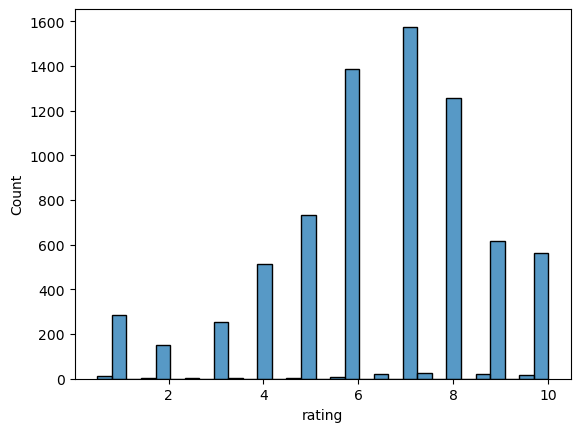

In [8]:
sns.histplot(df["rating"])

In [9]:
dist = FreqDist(df["rating"])

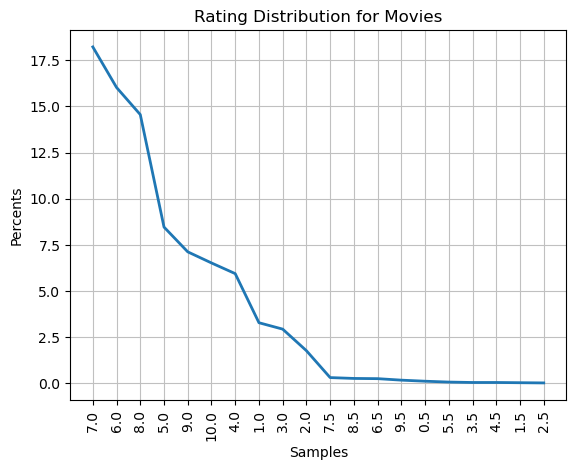

<Axes: title={'center': 'Rating Distribution for Movies'}, xlabel='Samples', ylabel='Percents'>

In [10]:
dist.plot(20, title='Rating Distribution for Movies', percents=True)

In [11]:
# Null Values
df.isnull().sum()

review_id            0
movie_id             0
imdb_id              0
original_title       0
review               0
rating            1196
dtype: int64

In [12]:
# Duplicate Values
df.duplicated().sum()

0

## Data Preprocessing

In [13]:
high_review = df.loc[df["rating"] >= 9]

In [14]:
low_review = df.loc[df["rating"] <=4]

In [15]:
high_review

,review_id,movie_id,imdb_id,original_title,review,rating
1,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation.",9.0
15,608e2744d8cc4a0058dc4272,2621,tt0122459,Return to Me,"Okay, I will admit I can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endings (I guess if they don’t end happily, they aren’t rom-coms).\r\n\r\nI saw this movie many years ago, but had forgotten just enough of it to keep it fresh for me. Like many movies, the plot relies on a huge coincidence or three. The story gets sappy and sentimental in places, is rather predictable and has too much religion to suit me, but that last thing may suit you just fine, praise be. It was co-written and directed by the actress Bonnie Hunt, who is a supporting character in the film.\r\n\r\nBut there is a spark of chemistry between the two lead characters, the dialogue is smart and sharp, and the movie is rich with its supporting cast, such as Jim Belushi, Robert Loggia and Archie Bunker - I mean Carroll O’Connor. Plus I have liked Minnie Driver since Circle of Friends. \r\n\r\nJust keep in mind this isn’t Hitchcock or Frank Capra stuff and doesn’t try to be. Just let it flow over you",9.0
21,5570c897c3a368709c000bca,2787,tt0134847,Pitch Black,"All you people are so scared of me. Most days I'd take that as a compliment. But it ain't me you gotta worry about now.\r\n\r\nPitch Black is directed by David Twohy and collectively written by Twohy and Ken and Jim Wheat. It stars Vin Diesel, Radha Mitchell, Cole Hauser, Keith David, Lewis Fitz-Gerald, Claudia Black and Rhiana Griffith. Music is by Graeme Revell and cinematography is by David Eggby. \r\n\r\nThe year 2000 was awash with sci-fi movies, not all were stellar of course, but siting at the top end of the scale was this, Twohy's super slice of action/horror/sci-fi cake. \r\n\r\nRight from the off we are thrust on board the cargo ship Hunter-Gratzner, which as it happens is plummeting through space. The ship has been hit by meteorite debris and junior officer Caroline Fly (Mitchell), after coming out of hyper sleep, manages to crash land on a nearby planet. Only a handful of passengers survive the crash, including infamous convict Richard B. Riddick (Diesel), but as the survivors struggle to cope with the threat from within the group, it becomes apparent that there's a bigger threat soon to join the party, a deadly alien species, a species that can only operate in the dark. Pity, then, that an eclipse is due... \r\n\r\nOkies, so lets get the obvious out in the open right away, Pitch Black is a variant of Alien, one of a ream of films that grabbed the coat tails of Ridley Scott's game changer. Yet this is still a fresh movie, a lesson in low budget film making with grace, style, blood, brains and balls - the execution grade ""A"" from those involved. \r\n\r\nIt's maybe surprising given the synopsis, to find that it's a very character driven piece, with Twohy continually building his characters even as the carnage and terror is unleashed - and these are a very diverse bunch of characters. One of the universe's baddest criminals, a spunky lady officer having to take command, a morphine addicted bounty hunter, an Islamic priest and his young companions, a camp alcoholic and a couple of strays. It's the not so wild bunch, but everyone of them are afforded chance to impact on the story before and during the inevitable picking off one by one at the claws of the beasts. \r\n\r\nThe narrative strength comes via Diesel's hulking convict, he's double jointed and has had optical surgery so he can see his enemies in the dark! The group must come to rely on him for he is clea

In [16]:
low_review

,review_id,movie_id,imdb_id,original_title,review,rating
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.\r\n\r\n_Final rating:★½: - Boring/disappointing. Avoid if possible._",3.0
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,"After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds... for 15 seconds. I am amazed they did decide to push on with more M:I movies after this one, then again, these turned out much much better even if it would be hard to beat that lousy piece of crap of a movie.",2.0
20,6409202f0e441900e887a17b,4234,tt0134084,Scream 3,"**_Scream 3’s_ lackluster screenplay and unimaginative kills leave a film that is a bore to watch.**\r\n\r\nThe meta-narrative of trilogies throughout the film does not make up for how abysmal the plot was. This film creates so much lore for the past movies seemingly out of the blue, muddling up the continuity for shock value. It added very little to this film and felt forced. The entire plot point of Sidney’s mother being a former Hollywood actress was pretty lame, especially with the added plot point of her being sexually assaulted by a movie producer. It may be personal taste, but I absolutely despise when films add that plot point, as it feels incredibly hypocritical since it is something that genuinely happens to an industry, they are involved in. The love triangle between Gale, Dewey, and the Gale actress was pretty dumb and felt undeserved, as we have not seen Gale and Dewey actually together in any of the films.\r\n\r\nIn horror films, you can have a good movie with a terrible plot as long as the kills are great. Unfortunately, Scream 3 continues the trend of having boring kills with no imagination. There has been only one truly unique kill throughout the entire franchise, and the rest are unbloody stab kills. I understand the meta being about stabbing with a knife, as the in-film movie is called Stab, but please add some gore to it. There is nothing, no blood squirts or body horror, and it caused the entire movie to be boring.\r\n\r\nOur performances were exactly how I would describe Scream 2, with both Neve Campbell and Courtney Cox being the standouts and David Arquette being average at best. All of the new characters were pretty uninteresting, all of the actors in the film were annoying, and the movie producers felt generic.\r\n\r\nThe direction of this film felt pretty uninspired. I am not sure if Wes Craven was forced to make this movie by the studio, but nothing about it felt unique and creative. It felt like he was phoning it in for a paycheck.\r\n\r\nOverall, there were not a lot of redeeming qualities for this film, and it left me feeling unfulfilled as the final credits rolled. Hoping Scream IV has more in store for me than this lackluster film.\r\n\r\n**Score:** _45%_\r\n**Verdict:** _Poor_",4.0
31,63578ba8c8a2d4008a00ff77,12211,tt0144964,Highlander: Endgame,"**There should have been only one!**\r\n\r\nIf “Highlander 2” was a complete disgrace and “Highlander 3” somehow tried to give us some compensation, this movie makes it look worse and more worn out. 

In [17]:
reviews = [low_review, high_review]

In [18]:
df_high_low_reviews = pd.concat(reviews)

In [19]:
df_high_low_reviews

,review_id,movie_id,imdb_id,original_title,review,rating
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.\r\n\r\n_Final rating:★½: - Boring/disappointing. Avoid if possible._",3.0
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,"After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds... for 15 seconds. I am amazed they did decide to push on with more M:I movies after this one, then again, these turned out much much better even if it would be hard to beat that lousy piece of crap of a movie.",2.0
20,6409202f0e441900e887a17b,4234,tt0134084,Scream 3,"**_Scream 3’s_ lackluster screenplay and unimaginative kills leave a film that is a bore to watch.**\r\n\r\nThe meta-narrative of trilogies throughout the film does not make up for how abysmal the plot was. This film creates so much lore for the past movies seemingly out of the blue, muddling up the continuity for shock value. It added very little to this film and felt forced. The entire plot point of Sidney’s mother being a former Hollywood actress was pretty lame, especially with the added plot point of her being sexually assaulted by a movie producer. It may be personal taste, but I absolutely despise when films add that plot point, as it feels incredibly hypocritical since it is something that genuinely happens to an industry, they are involved in. The love triangle between Gale, Dewey, and the Gale actress was pretty dumb and felt undeserved, as we have not seen Gale and Dewey actually together in any of the films.\r\n\r\nIn horror films, you can have a good movie with a terrible plot as long as the kills are great. Unfortunately, Scream 3 continues the trend of having boring kills with no imagination. There has been only one truly unique kill throughout the entire franchise, and the rest are unbloody stab kills. I understand the meta being about stabbing with a knife, as the in-film movie is called Stab, but please add some gore to it. There is nothing, no blood squirts or body horror, and it caused the entire movie to be boring.\r\n\r\nOur performances were exactly how I would describe Scream 2, with both Neve Campbell and Courtney Cox being the standouts and David Arquette being average at best. All of the new characters were pretty uninteresting, all of the actors in the film were annoying, and the movie producers felt generic.\r\n\r\nThe direction of this film felt pretty uninspired. I am not sure if Wes Craven was forced to make this movie by the studio, but nothing about it felt unique and creative. It felt like he was phoning it in for a paycheck.\r\n\r\nOverall, there were not a lot of redeeming qualities for this film, and it left me feeling unfulfilled as the final credits rolled. Hoping Scream IV has more in store for me than this lackluster film.\r\n\r\n**Score:** _45%_\r\n**Verdict:** _Poor_",4.0
31,63578ba8c8a2d4008a00ff77,12211,tt0144964,Highlander: Endgame,"**There should have been only one!**\r\n\r\nIf “Highlander 2” was a complete disgrace and “Highlander 3” somehow tried to give us some compensation, this movie makes it look worse and more worn out. 

In [20]:
#artifacts = ["href", "\r\n"]

In [21]:
#df_high_low_reviews["review"].str.contains(artifacts).sum()

## NLTK and SpaCy

In [22]:
# Remove Stopwords
from wordcloud import STOPWORDS


In [23]:
# Disable ner
nlp_no_ner = spacy.load("en_core_web_sm", disable=['ner'])
# Print active components
nlp_no_ner.pipe_names



['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']

In [24]:
#Tokenization
df_high_low_reviews['tokens'] = batch_preprocess_texts(
    df_high_low_reviews["review"],
    nlp=nlp_no_ner,
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=False,
    disable=["ner"],
    batch_size=50,
    n_process=-1,
)

2419it [00:28, 86.38it/s] 


In [25]:
# Tokenized-joined back to single string
df_high_low_reviews["joined_tokens"] = df_high_low_reviews['tokens'].map(lambda x: " ".join(x))

In [26]:
df_high_low_reviews['lemmas'] = batch_preprocess_texts(
    df_high_low_reviews["review"],
    nlp=nlp_no_ner,
    remove_stopwords=True,
    remove_punct=True,
    use_lemmas=True,
    disable=["ner"],
    batch_size=50,
    n_process=-1,
)

2419it [00:28, 85.24it/s] 


In [27]:
# Lemmatized-joined to single string
df_high_low_reviews["joined_lemmas"] = df_high_low_reviews['lemmas'].map(lambda x: " ".join(x))
df_high_low_reviews.head()

,review_id,movie_id,imdb_id,original_title,review,rating,tokens,joined_tokens,lemmas,joined_lemmas
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.\r\n\r\n_Final rating:★½: - Boring/disappointing. Avoid if possible._",3.0,"[underwhelmed, straight, bored, course, seeing, hunt, climb, mountain, harness, impressive, sure, liked, idea, villain, piece, angle, woefully, underdeveloped, setting, predominantly, australia, grab, attention, saying, cause, pretty, biased, comes, hear, tell, mission, impossible, ii, low, point, series, encouraging, worse, know, able, rogue, nation, final, rating:, ★, ½, boring, disappointing, avoid, possible]",underwhelmed straight bored course seeing hunt climb mountain harness impressive sure liked idea villain piece angle woefully underdeveloped setting predominantly australia grab attention saying cause pretty biased comes hear tell mission impossible ii low point series encouraging worse know able rogue nation final rating: ★ ½ boring disappointing avoid possible,"[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, encouraging, bad, know, able, rogue, nation, final, rating:, ★, ½, boring, disappointing, avoid, possible]",underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation final rating: ★ ½ boring disappointing avoid possible
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,"After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds... for 15 seconds. I am amazed they did decide to push on with more M:I movies after this one, then again, these turned out much much better even if it would be hard to beat that lousy piece of crap of a movie.",2.0,"[entertainign, mission, impossible, second, installment, turned, terrible, screenwriters, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scenes, horrible, need, barf, bag, stand, slo, mo, seconds, 15, seconds, amazed, decide, push, m, movies, turned, better, hard, beat, lousy, piece, crap, movie]",entertainign mission impossible second installment turned terrible screenwriters know fill 2 hrs action overuse heroic slow motion scenes horrible need barf bag stand slo mo seconds 15 seconds amazed decide push m movies turned better hard beat lousy piece crap movie,"[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]",entertainign mission impossible second installment turn terrible screenwriter know fill 2 hrs action overuse heroic

In [28]:
#Saving model
import joblib

joblib.dump(df_high_low_reviews, 'Data-NLP/df_high_low_reviews')

['Data-NLP/df_high_low_reviews']

## EDA and Visualization

In [29]:
# define custom stopwords
custom_stopwords = ["scene", "story", "one",'movie','film',"character", "like", "good","bad", *STOPWORDS]

In [30]:
# Create filters for 1 and 5 star reviews
filter_high = df_high_low_reviews['rating'] >= 9
filter_low = df_high_low_reviews['rating'] <= 4
filter_high.sum(), filter_low.sum()



(1195, 1224)

In [31]:
# Make a single giant string with high rating reviews
high_reviews_text = " ".join(df_high_low_reviews.loc[filter_high, 'review'])
print(high_reviews_text[:1000],"\n")



A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy animation. Okay, I will admit I can be a bit of an easy grader when it comes to romantic comedies, as long as they are witty with likable characters, don’t insult my intelligence and have suitable happy endings (I guess if they don’t end happily, they aren’t rom-coms).

I saw this movie many years ago, but had forgotten just enough of it to keep it fresh for me. Like many movies, the plot relies on a huge coincidence or three. The story gets sappy and sentimental in places, is rather predictable and has too much religion to suit me, but that last thing may suit you just fine, praise be. It was co-written and directed by the actress Bonnie Hunt, who is a supporting character in the film.

But there is a spark of chemistry between the two lead cha 



In [32]:
# Make a single giant string with low rating reviews
low_reviews_text = " ".join(df_high_low_reviews.loc[filter_low, 'review'])
print(low_reviews_text[:1000],"\n")



The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).

Even setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.

_Final rating:★½: - Boring/disappointing. Avoid if possible._ After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every f 



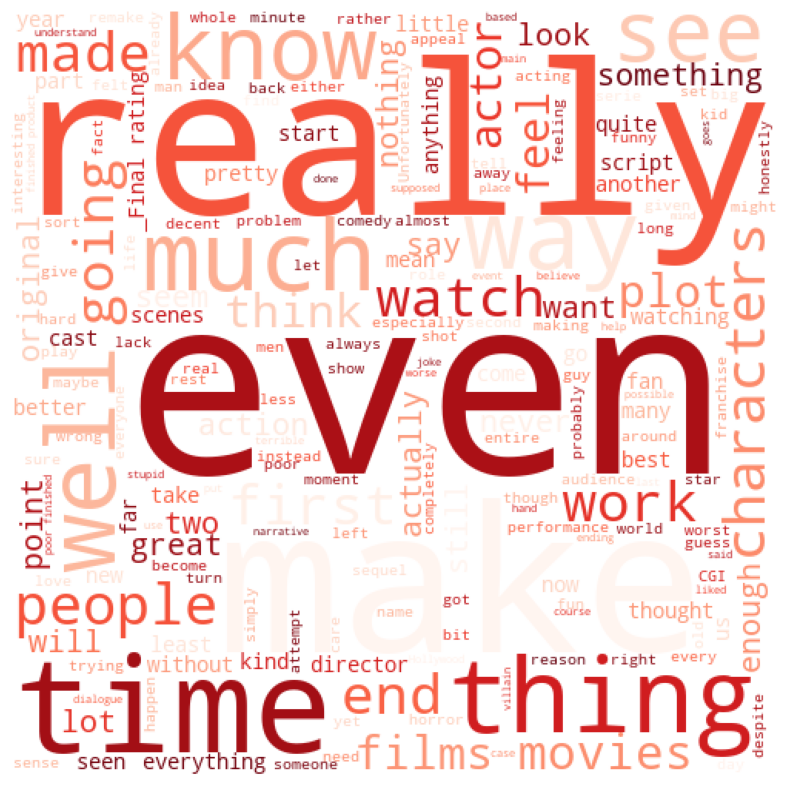

In [33]:
# Low Review Word Cloud
bad_cloud = WordCloud(
    random_state=123,
    stopwords = custom_stopwords,
    background_color="white",
    width = 500,
    height = 500,
    max_words=200,
    colormap="Reds",
    min_word_length=2,
).generate(low_reviews_text)
plt.figure(figsize = (10, 10))
plt.imshow(bad_cloud)
plt.axis("off");



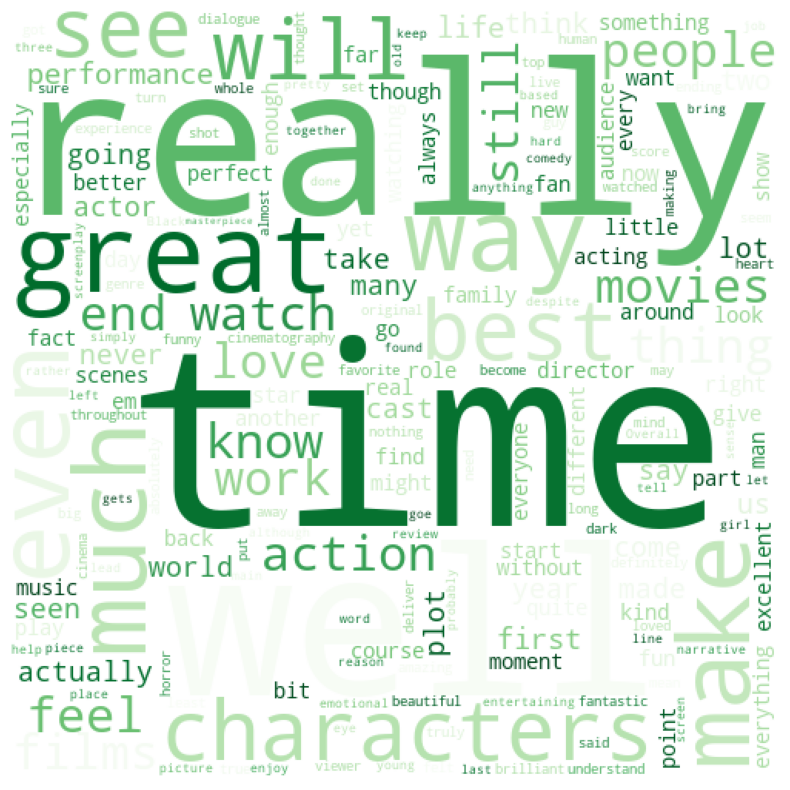

In [34]:
# High review word cloud
good_cloud = WordCloud(
    random_state=123,
    stopwords = custom_stopwords,
    background_color="white",
    width = 500,
    height = 500,
    max_words=200,
    colormap="Greens",
    min_word_length=2,
).generate(high_reviews_text)
plt.figure(figsize = (10, 10))
plt.imshow(good_cloud)
plt.axis("off");



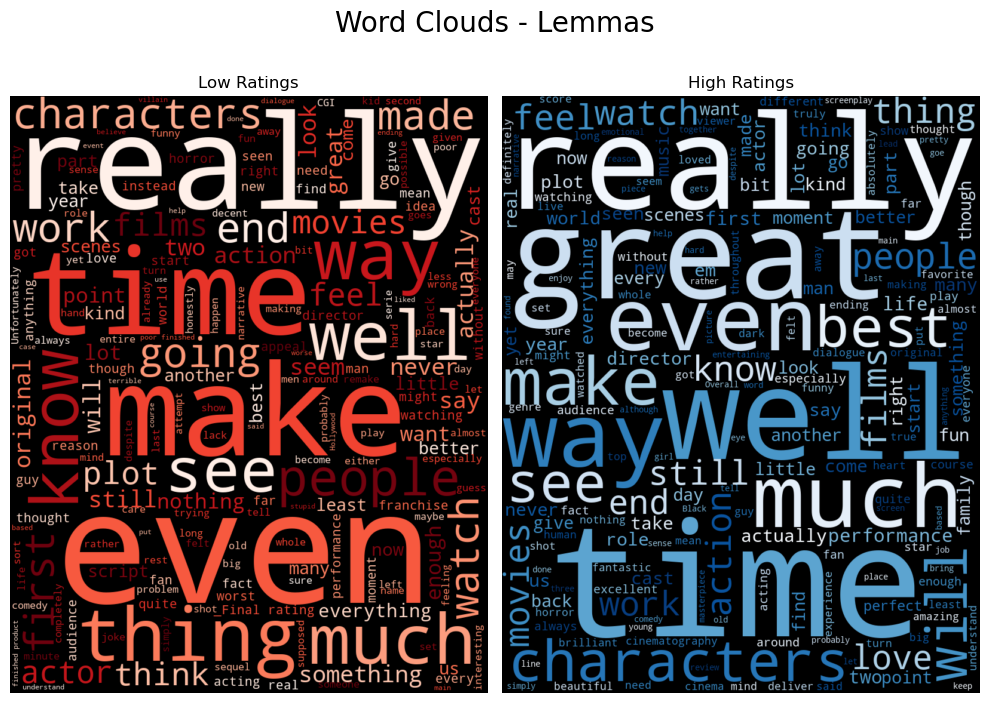

In [35]:
# Make word clouds of lemmas with custom stopwords
# Create an instance of a WordCloud and use the generate method
low_cloud = WordCloud(random_state = 42,
                      width = 800,
                      height = 1000,
                      min_word_length = 2, colormap="Reds",
                      stopwords = custom_stopwords
                     ).generate(low_reviews_text)
high_cloud = WordCloud(random_state = 42,
                       width = 800,
                       height= 1000,
                       min_word_length = 2,
                       colormap="Blues",
                       stopwords = custom_stopwords
                      ).generate(high_reviews_text)
# Plot the wordclouds side by side
fig, axes = plt.subplots(ncols=2, figsize=(10, 7))
axes[0].imshow(low_cloud, interpolation='bilinear')
axes[0].set_title("Low Ratings")
axes[1].imshow(high_cloud, interpolation='bilinear')
axes[1].set_title("High Ratings")
[ax.axis('off') for ax in axes]
fig.tight_layout();
fig.suptitle('Word Clouds - Lemmas', fontsize=20, y=1.05);



## Frequency Distribution

In [36]:
# Create lists of all lemmas in both high and low review groups
high_review_lemmas_list = df_high_low_reviews.loc[filter_high, 'lemmas'].explode().astype(str).to_list()
low_review_lemmas_list = df_high_low_reviews.loc[filter_low, 'lemmas'].explode().astype(str).to_list()



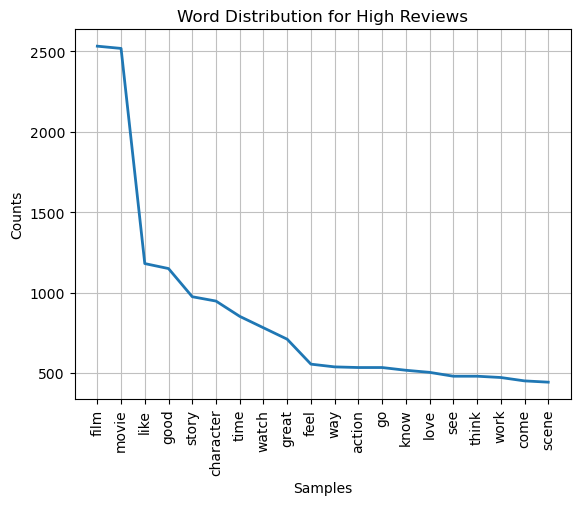

<Axes: title={'center': 'Word Distribution for High Reviews'}, xlabel='Samples', ylabel='Counts'>

In [37]:
# Plot distribution of words in high reviews
high_dist = FreqDist(high_review_lemmas_list)
high_dist.plot(20, title='Word Distribution for High Reviews')

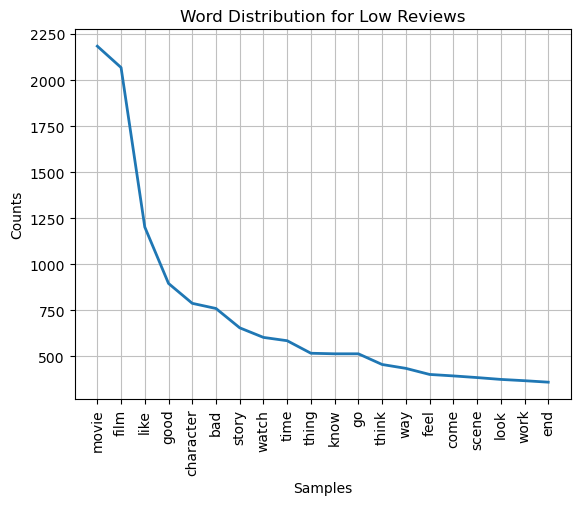

<Axes: title={'center': 'Word Distribution for Low Reviews'}, xlabel='Samples', ylabel='Counts'>

In [38]:
# Plot distribution of words in low reviews
low_dist = FreqDist(low_review_lemmas_list)
low_dist.plot(20, title='Word Distribution for Low Reviews')

## NGrams

In [39]:
# Obtain single list of tokens from all high reviews
high_reviews_tokens_exploded_list = df_high_low_reviews.loc[filter_high, 'tokens'].explode().astype(str).to_list()
high_reviews_tokens_exploded_list[:5]



['guilty', 'pleasure', 'personally', 'love', 'great']

In [40]:
# Obtain single list of tokens from all low reviews
low_reviews_tokens_exploded_list = df_high_low_reviews.loc[filter_low, 'tokens'].explode().astype(str).to_list()
low_reviews_tokens_exploded_list[:5]



['underwhelmed', 'straight', 'bored', 'course', 'seeing']

In [41]:
# Bigrams of low reviews
bi_low = get_ngram_measures_finder(low_reviews_tokens_exploded_list, ngrams=2, top_n=20)



In [42]:
# Bigrams of high reviews
bi_high = get_ngram_measures_finder(high_reviews_tokens_exploded_list, ngrams=2, top_n=20)



In [43]:
# Trigrams of low reviews
tri_low = get_ngram_measures_finder(low_reviews_tokens_exploded_list, ngrams=3, top_n=20)



In [44]:
# Trigrams of high reviews
tri_high = get_ngram_measures_finder(high_reviews_tokens_exploded_list, ngrams=3, top_n=20)



In [45]:
ngrams_list = [bi_low,bi_high,tri_low,tri_high]

In [46]:
compare_ngrams = pd.concat(ngrams_list)

The low rated reviews had ngrams that refered to the movie being boring or disappointing and not looking great often while the highly reviewed movies had ngrams that referred to action and special effects alot. The bigrams were a bit more telling than the trigrams as the trigrams contained more symbols and links. With additional cleaning, the trigrams may glean more information.

In [47]:
ngram_table = compare_ngrams.head(30).to_markdown()

In [48]:
print(ngram_table)

|    | Words                       |    Raw Freq |
|---:|:----------------------------|------------:|
|  0 | ('final', 'rating')         | 0.00112837  |
|  1 | ('rating', '★')             | 0.00112837  |
|  2 | ('★', '★')                  | 0.0010314   |
|  3 | ('finished', 'product')     | 0.000846277 |
|  4 | ('appeal', 'poor')          | 0.000837462 |
|  5 | ('poor', 'finished')        | 0.000837462 |
|  6 | ('things', 'appeal')        | 0.000837462 |
|  7 | ('★', 'things')             | 0.000837462 |
|  8 | ('special', 'effects')      | 0.000643523 |
|  9 | ('feels', 'like')           | 0.000537739 |
| 10 | ('★', '½')                  | 0.000528923 |
| 11 | ('avoid', 'possible')       | 0.000511293 |
| 12 | ('boring', 'disappointing') | 0.000511293 |
| 13 | ('disappointing', 'avoid')  | 0.000511293 |
| 14 | ('½', 'boring')             | 0.000511293 |
| 15 | ('final', 'rating:')        | 0.000502477 |
| 16 | ('rating:', '★')            | 0.000502477 |
| 17 | ('looks', 'like')       

|    | Words                       |    Raw Freq |
|---:|:----------------------------|------------:|
|  0 | ('final', 'rating')         | 0.00112837  |
|  1 | ('rating', '★')             | 0.00112837  |
|  2 | ('★', '★')                  | 0.0010314   |
|  3 | ('finished', 'product')     | 0.000846277 |
|  4 | ('appeal', 'poor')          | 0.000837462 |
|  5 | ('poor', 'finished')        | 0.000837462 |
|  6 | ('things', 'appeal')        | 0.000837462 |
|  7 | ('★', 'things')             | 0.000837462 |
|  8 | ('special', 'effects')      | 0.000643523 |
|  9 | ('feels', 'like')           | 0.000537739 |
| 10 | ('★', '½')                  | 0.000528923 |
| 11 | ('avoid', 'possible')       | 0.000511293 |
| 12 | ('boring', 'disappointing') | 0.000511293 |
| 13 | ('disappointing', 'avoid')  | 0.000511293 |
| 14 | ('½', 'boring')             | 0.000511293 |
| 15 | ('final', 'rating:')        | 0.000502477 |
| 16 | ('rating:', '★')            | 0.000502477 |
| 17 | ('looks', 'like')           | 0.000405508 |
| 18 | ('good', 'movie')           | 0.000352616 |
| 19 | ('star', 'wars')            | 0.000352616 |
|  0 | ('comic', 'book')           | 0.000436441 |
|  1 | ('special', 'effects')      | 0.000436441 |
|  2 | ('star', 'wars')            | 0.000393512 |
|  3 | ('sci', 'fi')               | 0.000357738 |
|  4 | ('feel', 'like')            | 0.000350583 |
|  5 | ('action', 'movie')         | 0.000343429 |
|  6 | ('watch', 'movie')          | 0.00031481  |
|  7 | ('john', 'wick')            | 0.000307655 |
|  8 | ('real', 'life')            | 0.000307655 |
|  9 | ('long', 'time')            | 0.0003005   |

## Sentiment Analysis

In [49]:
# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()



In [50]:
# Add sentiment scores to the reviews df
df_high_low_reviews['sentiment_scores'] = df_high_low_reviews['review'].map(sia.polarity_scores)
# Convert the column of dictionaries into separate columns
review_scores = df_high_low_reviews['sentiment_scores'].apply(pd.Series)
# Join the new DataFrame with the original DataFrame
reviews = pd.concat([df_high_low_reviews, review_scores], axis=1).drop('sentiment_scores', axis=1)
reviews.head()



,review_id,movie_id,imdb_id,original_title,review,rating,tokens,joined_tokens,lemmas,joined_lemmas,neg,neu,pos,compound
6,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully underdeveloped).\r\n\r\nEven setting it in predominantly Australia was enough to grab my attention, and that's saying something cause I'm pretty biased when it comes to that. I hear tell that _Mission: Impossible II_ is the low point in the series, and that at least is encouraging, because if anything afterwards is much worse than this one, I don't know if I'll be able to make it through to Rogue Nation.\r\n\r\n_Final rating:★½: - Boring/disappointing. Avoid if possible._",3.0,"[underwhelmed, straight, bored, course, seeing, hunt, climb, mountain, harness, impressive, sure, liked, idea, villain, piece, angle, woefully, underdeveloped, setting, predominantly, australia, grab, attention, saying, cause, pretty, biased, comes, hear, tell, mission, impossible, ii, low, point, series, encouraging, worse, know, able, rogue, nation, final, rating:, ★, ½, boring, disappointing, avoid, possible]",underwhelmed straight bored course seeing hunt climb mountain harness impressive sure liked idea villain piece angle woefully underdeveloped setting predominantly australia grab attention saying cause pretty biased comes hear tell mission impossible ii low point series encouraging worse know able rogue nation final rating: ★ ½ boring disappointing avoid possible,"[underwhelme, straight, bore, course, see, hunt, climb, mountain, harness, impressive, sure, like, idea, villain, piece, angle, woefully, underdeveloped, set, predominantly, australia, grab, attention, say, cause, pretty, biased, come, hear, tell, mission, impossible, ii, low, point, series, encouraging, bad, know, able, rogue, nation, final, rating:, ★, ½, boring, disappointing, avoid, possible]",underwhelme straight bore course see hunt climb mountain harness impressive sure like idea villain piece angle woefully underdeveloped set predominantly australia grab attention say cause pretty biased come hear tell mission impossible ii low point series encouraging bad know able rogue nation final rating: ★ ½ boring disappointing avoid possible,0.186,0.704,0.110,-0.8724
7,5e9120963679a10018375490,955,tt0120755,Mission: Impossible II,"After quite entertainign Mission Impossible I the second installment turned out ... terrible. As if the screenwriters didn't know how to fill the 2 hrs with action the overuse of heroic slow motion scenes is horrible. You almost might need a barf bag if you can't stand slo-mo every five seconds... for 15 seconds. I am amazed they did decide to push on with more M:I movies after this one, then again, these turned out much much better even if it would be hard to beat that lousy piece of crap of a movie.",2.0,"[entertainign, mission, impossible, second, installment, turned, terrible, screenwriters, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scenes, horrible, need, barf, bag, stand, slo, mo, seconds, 15, seconds, amazed, decide, push, m, movies, turned, better, hard, beat, lousy, piece, crap, movie]",entertainign mission impossible second installment turned terrible screenwriters know fill 2 hrs action overuse heroic slow motion scenes horrible need barf bag stand slo mo seconds 15 seconds amazed decide push m movies turned better hard beat lousy piece crap movie,"[entertainign, mission, impossible, second, installment, turn, terrible, screenwriter, know, fill, 2, hrs, action, overuse, heroic, slow, motion, scene, horrible, need, barf, bag, stand, slo, mo, second, 15, second, amazed, decide, push, m, movie, turn, well, hard, beat, lousy, piece, crap, movie]",entertainign mission impossible second installment turn terrible scr

In [51]:
# Define filter for positive reviews
pos_sentiment_reviews = reviews['compound'] > 0
pos_sentiment_reviews.sum()



1633

In [52]:
# Identify reviews with a positive sentiment score that received low ratings
filter_mismatch_A = (reviews['rating'] <= 4) & pos_sentiment_reviews
pos_sent_9 = reviews.loc[filter_mismatch_A,['review','rating','compound']]
pos_sent_9.head()



,review,rating,compound
72,"WHAT A GREAT CAST FOR SUCH A CHEAP FILM.\r\n\r\nDescription:\r\nThree college students base their class project around gossip and how fast it spreads, which soon spirals out of control.\r\n\r\nReview:\r\nGossip is a Dramatic Thriller that was made fifteen years too late. The story sounds like something that could have been believable in the 80's but not for the 2000s, rape kits and a thorough investigation solves the plot. It's pretty to look at and the cast is excellent but the rest of it is unbelievable.",4.0,0.8695
111,"Pretty typical movie from the early aughts with attractive twenty-somethings in the leads and bland ""rock"" pop music, alongside an overly dramatic score. The acting is so-so at best and really bad story to go along with a laughable ending. Led to two direct-to-video sequels that I'm really not too keen to revisit. **2.0/5**",4.0,0.6523
125,"**An excuse to make a film full of women swaying seductively without a hint of softcore.**\r\n\r\nWhat can we say about a romantic film, with light touches of comedy, that spends most of its time showing us very attractive women in tight, short clothes, and bouncing around sensually in an atmosphere of mockery and debauchery worthy of a university graduation party? A lot of things. What leaves us no doubt? It is a film made with an openly and openly heterosexual audience in mind. Released in 2000, I don't know if the film would be possible today without being immediately accused of sexism and giving a stereotypical and sexualized image of women.\r\n\r\nLet's start by talking about the good things. One of them, perhaps the best, is the extraordinary soundtrack, which compiles excellent songs into one of the best non-original soundtracks of the decade: “The Right Kind of Wrong” and “Can't Fight the Moonlight” are so good that the entire we know them. The music is so important here that, in a sense, it is more of a music video than a film: the protagonist is an aspiring songwriter who tries to make it in the music market without much success, but who discovers that she sings well and becomes one of the main attractions. of a nightclub.\r\n\r\nThe scenarios are convincing enough for us to believe them, especially if it is known that there really is a bar of this type in New York (in fact, it seems that others in the same franchise have already opened). Even so, there is so much exaggeration at parties that it is, in my eyes, difficult to believe in a certified and legal commercial space. Minimally decent editing, but sometimes lax, and cinematography that relies too heavily on red tones complete, on a less positive note, the more technical aspects of this film.\r\n\r\nIn addition to the good songs, we have the beauty of the cast, with young and slender actresses, who make up for their inexperience with fantastic bodies and good dancing skills: Piper Perabo, Maria Bello, Tyra Banks, Izabella Miko, Bridget Moynahan and Adam Garcia. It's a shame that physical beauty doesn't translate into talent: as the cast wasn't chosen based on the actors' abilities, none of them offer an inspired performance. They are a bunch of complete scoundrels and the film, at this point, is very weak. In the interest of justice, it is imperative to save the renowned John Goodman, the only good actor here, who shows us what it is like to act in a character full of grace and quite comical.\r\n\r\nAll of these, however, are mere stumbling blocks on the long road of a production that could, even so, be frankly good if it told us a good story. It is in the script and the story told that the film falls to the ground like an aspiring model who breaks both heels while parading. When watching the film, I asked myself over and over again where the hell the script was, because all that, that whole trip to the city, to a future in show business, is so absolutely cliché and has already been repeated so much that it is unacceptable. There is no substance. Then, all that sugary romance, 

In [53]:
# Identify high reviews with negative sentiment
filter_mismatch_B = (reviews['rating'] >= 9) & ~pos_sentiment_reviews
reviews.loc[filter_mismatch_B,['review','rating','compound']].head()



,review,rating,compound
22,"One of those few movies that most people don't care for, but I personally think is **criminally** underrated.\r\n\r\n_Final rating:★★★★½ - Ridiculously strong appeal. I can’t stop thinking about it._",9.0,-0.3391
59,"Dazzling Björk in this indictment against the death sentence, in tight close-ups. This film is a UFO, musical without being.",10.0,-0.5574
75,"Shattering expose of the fallible human condition.\r\n\r\nWhat to say about Darren Aronofsky's Requiem for a Dream that hasn't been said already? Without doubt it's a film, that in spite of its high standing on the main movie sites, polarises opinions. It's a film that in simple terms follows four people through their addictions until the shattering denouement, but the journey is made more bleak by offering tantalising snatches of hope, the dreams of the protags offered up as some sort of goals for the addicts to cling on to - only for the narrative to stick in its rusty serrated blade to draw the lifeblood from the hapless hopefuls.\r\n\r\nArononfsky brings a multitude of technical skills to the party that emphasise the emotional discord on show. Standard split-screening is married up with rapid cutting, isolated framing, close ups, long tracking and Snorricam, all of which is sound tracked by Clint Mansell's haunting musical composition. All told it's an assault on all the senses and terrifying with it, boosted no end by Aronofsky getting top performances from his cast of actors. Love it or hate it, it's a film that simply can't be ignored, unsparing cinema produced by a most gifted director. 9/10",9.0,-0.7907
117,"I'll see you soon!\r\n\r\nBefore taking off for Paris, Alex Browning has a vision that the plane is going to explode. Pannicking he gets off the plane and in the mêlée a teacher and a group of his class mates are forced off the flight, the plane goes on to explode in mid air, killing everyone on board. But pretty soon after the disaster strange accidents start to befall those who got off the plane, it seems that death is out to get them.\r\n\r\nWith the number of hugely disappointing teens in peril movies that were made post the success of Wes Craven's hugely successful Scream, it's refreshing to find one that was, well, refreshing. Not purporting to be anything other than a wickedly entertaining piece of horror based nonsense, Final Destination is inventive, funny and above all else, shock laden.\r\n\r\nFrom the opening, and terrifying air crash sequence to the clever and gross way that our protagonists shake hands with the grim reaper, this film is gloriously proud of its horror intent. One peak at the surnames of the characters will tell you just how into their horror roots the makers are here, whilst not a homage movie as such, James Wong and his team clearly know what makes a modern horror picture work.\r\n\r\nIf you find yourself complaining about the writing then you clearly are missing the point of Final Destination's existence, either that or you are in fact dead yourself! Four fun but vastly inferior sequels would follow, but really this is the one to watch, as good a 100 minutes of horror fun as you could wish to have. I dare you not to jump out your seat at least once! 9/10",9.0,-0.9920
254,"There can't be such devils out there. \r\n\r\nThe Pledge is directed by Sean Penn and adapted to screenplay by Jerzy Kromolowski and Mary Olson-Kromolowski from Friedrich Dürrenmatt's novel, ""The Promise"". It stars Jack Nicholson, Robin Wright Penn, Aaron Eckhart, Sam Shepard, Patricia Clarkson, Helen Mirren, Tom Noonan, Benicio Del Toro, Mickey Rourke, Dale Dickey, Vanessa Redgrave and Harry Dean Stanton. Music is by Klaus Badelt and Hans Zimmer, and cinematography by Chris Menges.\r\n\r\nPolice chief Jerry Black (Nicholson) is literally on his last day before retitement. But during his leaving party news filters through that a young girl has been brutally murdered. Talking his chiefs into letting him tag along to the crime scene, 

The mismatched sentiment for the highly rated movies appear to be becasue the movies themselves had a darker tone so when writing about them the reviewers used words that are generally considered more negative. The mismatched sentiment for the poorly rated movies seem to be related to the bits of praise reviewers have for them or more often sarcasm found in the reviewers comments. The nature of the movies also seem to be more lighthearted so more positive words are used in general.

## Evaluation and Reporting

To make a highly-rated movie, these three things appear to be important:
1. Good Visuals
2. Action/Excitement
3. Have charming or relatable characters

Poorly rated movies seem to have these three things in common:
1. Boring
2. Look bad or unfinished
3. Uninteresting or unlikeable characters